### Bibliotecas

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb

from scipy import stats
import itertools

from copy import deepcopy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Lendo Dados

In [2]:
df = pd.read_csv('./Data/volve_preproc.csv')
df.shape

(23733, 10)

#### Filtering Data

In [3]:
n=3
df2 = df[::n]
df2.shape

(7911, 10)

In [4]:
df_filt = df2.dropna()
df_filt.shape

(1773, 10)

In [5]:
df.groupby('wellName').count()

,MD,CALI,DT,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,,
15/9-F-1 A,2099,2099,2099,2099,2099,2099,2099,2099,2099
15/9-F-1 B,1903,1903,1903,1903,1903,1903,1903,1903,1903
15/9-F-1 C,7631,7631,0,7631,7631,7631,7630,7630,7631
15/9-F-11 A,1402,1402,1402,1402,1402,1402,1321,1321,1402
15/9-F-11 B,10698,10698,0,10698,10698,10698,10698,10698,10698


In [6]:
df2.groupby('wellName').count()

,MD,CALI,DT,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,,
15/9-F-1 A,700,700,700,700,700,700,700,700,700
15/9-F-1 B,634,634,634,634,634,634,634,634,634
15/9-F-1 C,2544,2544,0,2544,2544,2544,2543,2543,2544
15/9-F-11 A,467,467,467,467,467,467,439,439,467
15/9-F-11 B,3566,3566,0,3566,3566,3566,3566,3566,3566


In [7]:
df_filt.groupby('wellName').count()

,MD,CALI,DT,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,,
15/9-F-1 A,700,700,700,700,700,700,700,700,700
15/9-F-1 B,634,634,634,634,634,634,634,634,634
15/9-F-11 A,439,439,439,439,439,439,439,439,439


### Treinando modelo de ML para prever DT

#### Definindo a parcela de treino e de teste

In [8]:
training_wells = ['15/9-F-11 A', '15/9-F-1 A']
test_wells = ['15/9-F-1 B']
nodata_wells = ['15/9-F-11 B', '15/9-F-1 C'] #poços sem a informação de DT

In [9]:
train_df = df_filt[df_filt['wellName'].isin(training_wells)]
test_df = df_filt[df_filt['wellName'].isin(test_wells)]
nodata_df = df_filt[df_filt['wellName'].isin(nodata_wells)]

#### Selecionando variáveis de entrada e saída

In [10]:
inputs = [
    # 'CALI',
    # 'DT',
    'GR',
    'NPHI',
    'RHOB',
    'PHIF',
    # 'SW',
    'RACEHM_LOG'
    ]

output = ['DT']

In [11]:
X_tr = train_df[inputs]
y_tr = train_df[output]
X_tr.columns, y_tr.columns

(Index(['GR', 'NPHI', 'RHOB', 'PHIF', 'RACEHM_LOG'], dtype='object'),
 Index(['DT'], dtype='object'))

In [12]:
X_te = test_df[inputs]
y_te = test_df[output]
X_te.columns, y_te.columns

(Index(['GR', 'NPHI', 'RHOB', 'PHIF', 'RACEHM_LOG'], dtype='object'),
 Index(['DT'], dtype='object'))

In [13]:
X_tr.shape,y_tr.shape,X_te.shape,y_te.shape

((1139, 5), (1139, 1), (634, 5), (634, 1))

In [14]:
X_tr = X_tr.values
X_te = X_te.values
y_tr = y_tr.values
y_te = y_te.values

#### Normalizando dados MinMax

In [15]:
Xtr_scaler = MinMaxScaler()
ytr_scaler = MinMaxScaler()
Xte_scaler = MinMaxScaler()
yte_scaler = MinMaxScaler()
X_tr = Xtr_scaler.fit_transform(X_tr)
X_te = Xte_scaler.fit_transform(X_te)
y_tr = ytr_scaler.fit_transform(y_tr)
y_te = yte_scaler.fit_transform(y_te)

Random State

In [16]:
rs=48

#### Declarando os Modelos ML

In [17]:
models_ml = [
    ('LinReg'              ,      LinearRegression(copy_X=True)), #ARX Equivalet
    ('PolyReg'             ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivale)t
    ('SVM'                 ,      SVR(max_iter=-1)),
    ('KNN'                 ,      KNeighborsRegressor()),
    ('MLP'                 ,      MLPRegressor(random_state=rs)),
    ('DecisionTree'        ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'        ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting'    ,      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'          ,      ExtraTreesRegressor(random_state=rs)),
    ('AdaBoostRegressor'   ,      AdaBoostRegressor(random_state=rs)),
    ('BaggingRegressor'    ,      BaggingRegressor(random_state=rs)),
    ('LightGBM'            ,      lgb.LGBMRegressor()),
    ('XGBoost'             ,      xgb.XGBRegressor()),
]


In [18]:
for i, m in enumerate(models_ml):
    print (i, m[1])

0 LinearRegression()
1 Pipeline(steps=[('Poly', PolynomialFeatures()), ('Reg', LinearRegression())])
2 SVR()
3 KNeighborsRegressor()
4 MLPRegressor(random_state=48)
5 DecisionTreeRegressor(random_state=48)
6 RandomForestRegressor(random_state=48)
7 GradientBoostingRegressor(random_state=48)
8 ExtraTreesRegressor(random_state=48)
9 AdaBoostRegressor(random_state=48)
10 BaggingRegressor(random_state=48)
11 LGBMRegressor()
12 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight

#### Parâmetros (RandomSearchCV)

In [19]:
parameters = [
    { # LinReg 0
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # PolyReg NARX 1
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # SVM 2
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # KNN 3
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # MLP 6
        'activation'            : ['relu', 'tanh'],
        'early_stopping'        : [True],
        'learning_rate_init'    : stats.loguniform(1e-4, 0.01),
        # 'learning_rate'         : ['adaptive', 'constant'],
        'alpha'                 : stats.loguniform(1e-5, 1e-3),
        'hidden_layer_sizes'    : []
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=3)],
        # + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=4)],
        # 'max_iter'              : [10000],#stats.randint(200,10000),
        # 'batch_size'            : [32],
        # 'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),
    },
    { # DecisionTree 7
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RandomForest 8
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # GradientBoosting 9
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(),
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # ExtraTrees 10
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # AdaBoostRegressor 11
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 10),
        'loss'                      : ['linear', 'square', 'exponential'],
    },
    { # BaggingRegressor 12
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'max_samples'               : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_features'              : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'bootstrap'                 : [True, False],      #maxima quantidade de features para embasar a decisao de divisao
    },
    { # LightGBM 13
        'num_leaves'                : stats.randint(5,100), # max num folhas dos base learners
        'n_estimators'              : stats.randint(10,200), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 1),
        # 'max_depth'                 : stats.randint(1,20), #maxima profundidade da arvore
    },
    { # XGBoost 14
        'n_estimators'           : stats.randint(2,100), #Numero de arvores
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'learning_rate'          : stats.loguniform(1e-3, 1),
    },
]
# parameters

In [20]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=rs)
rkf

RepeatedKFold(n_repeats=10, n_splits=5, random_state=48)

#### Random Search

In [21]:
n_iter = 100 #Numero de iterações do rdmsearch
models=[]
for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2',
                                   param_distributions=params, n_iter=n_iter, n_jobs=6,
                                   cv=rkf, random_state=rs)

    models.append(
        (model[0], model[1], rdmsearch)
    )

models

[('LinReg',
  LinearRegression(),
  RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=48),
                     estimator=LinearRegression(), n_iter=100, n_jobs=6,
                     param_distributions={'positive': [True, False]},
                     random_state=48, scoring='r2')),
 ('PolyReg',
  Pipeline(steps=[('Poly', PolynomialFeatures()), ('Reg', LinearRegression())]),
  RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=48),
                     estimator=Pipeline(steps=[('Poly', PolynomialFeatures()),
                                               ('Reg', LinearRegression())]),
                     n_iter=100, n_jobs=6,
                     param_distributions={'Reg__positive': [True, False]},
                     random_state=48, scoring='r2')),
 ('SVM',
  SVR(),
  RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=48),
                     estimator=SVR(), n_iter=100, n_jobs=6,
                     p

#### Looping de Treinamento

In [22]:
res_dict = {
    'MODEL':[],
    'R2_TR':[],
    'R2_TE':[],
    'MAE_TR':[],
    'MAE_TE':[],
    'MODEL_OBJ':[],
}

best_r2 = 0
t00 = datetime.now()
for model in models:
    t0 = datetime.now()
    model_name, model_estim, model_instance = model
    print(f'{model_name}  ',end='')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    model_instance.fit(X=X_tr, y=y_tr);

    y_hat_tr = model_instance.predict(X_tr)
    y_hat_te = model_instance.predict(X_te)
    r2_tr = r2_score(y_tr, y_hat_tr)
    r2_te = r2_score(y_te, y_hat_te)
    mae_tr = mean_absolute_error(y_tr, y_hat_tr)
    mae_te = mean_absolute_error(y_te, y_hat_te)

    res_dict['MODEL'].append(model_name)
    res_dict['R2_TR'].append(r2_tr)
    res_dict['R2_TE'].append(r2_te)
    res_dict['MAE_TR'].append(mae_tr)
    res_dict['MAE_TE'].append(mae_te)
    res_dict['MODEL_OBJ'].append(deepcopy(model_instance))
    print(f'R2(TR,TE)={r2_tr:.3f}->{r2_te:.3f} / MAE(TR,TE)={mae_tr:.3f}->{mae_te:.3f}', end='')
    if r2_te>best_r2:
        best_r2=r2_te
        print(f'-------------------Best! {best_r2:.2f}')
    else:
        print()

    print(f'Tempo (modelo): {datetime.now()-t0}\nTempo (acum): {datetime.now()-t00}\n')


LinReg  R2(TR,TE)=0.818->0.791 / MAE(TR,TE)=0.070->0.070-------------------Best! 0.79
Tempo (modelo): 0:00:02.286369
Tempo (acum): 0:00:02.286369

PolyReg  R2(TR,TE)=0.837->0.757 / MAE(TR,TE)=0.066->0.079
Tempo (modelo): 0:00:00.102263
Tempo (acum): 0:00:02.388632

SVM  R2(TR,TE)=0.843->0.807 / MAE(TR,TE)=0.065->0.069-------------------Best! 0.81
Tempo (modelo): 0:00:21.907285
Tempo (acum): 0:00:24.295917

KNN  R2(TR,TE)=1.000->0.727 / MAE(TR,TE)=0.000->0.078
Tempo (modelo): 0:00:05.036913
Tempo (acum): 0:00:29.332830

MLP  R2(TR,TE)=0.860->0.616 / MAE(TR,TE)=0.060->0.100
Tempo (modelo): 0:18:00.679586
Tempo (acum): 0:18:30.012416

DecisionTree  R2(TR,TE)=0.871->0.787 / MAE(TR,TE)=0.057->0.068
Tempo (modelo): 0:00:06.138868
Tempo (acum): 0:18:36.151284

RandomForest  R2(TR,TE)=0.933->0.782 / MAE(TR,TE)=0.041->0.072
Tempo (modelo): 0:02:37.685416
Tempo (acum): 0:21:13.836700

GradientBoosting  R2(TR,TE)=0.969->0.733 / MAE(TR,TE)=0.027->0.079
Tempo (modelo): 0:05:18.072866
Tempo (acum): 

In [173]:
df_results = pd.DataFrame(res_dict)
df_results.drop(['INPUTS', 'OUTPUT', 'BEST'], axis=1, inplace=True)

In [174]:
df_results['IN'] = '.'.join(inputs)
df_results['OUT'] = output[0]
df_results

,MODEL,R2_TR,R2_TE,MAE_TR,MAE_TE,MODEL_OBJ,IN,OUT
0,LinReg,0.817558,0.791211,0.070220,0.069740,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
1,PolyReg,0.837098,0.756749,0.065815,0.078860,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
2,SVM,0.843019,0.807220,0.064646,0.068609,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
3,KNN,1.000000,0.727441,0.000000,0.078282,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
4,MLP,0.859872,0.615783,0.060110,0.099999,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
5,DecisionTree,0.871461,0.786512,0.056581,0.067599,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
6,RandomForest,0.932981,0.782344,0.041232,0.071521,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
7,GradientBoosting,0.969359,0.732892,0.026894,0.078834,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
8,ExtraTrees,0.893694,0.780073,0.051972,0.073009,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
9,AdaBoostRegressor,0.833461,0.818034,0.070991,0.059110,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT


(0.5, 1.0)

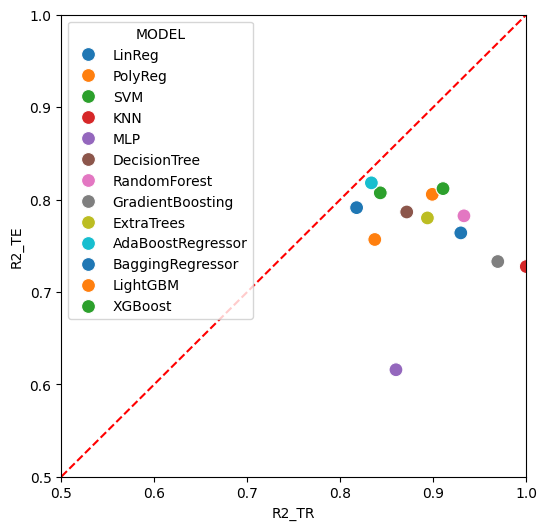

In [175]:
lim = (0.5, 1)
fsize = (6, 6)

plt.figure(figsize=fsize)
sns.scatterplot(data=df_results, y='R2_TE', x='R2_TR', hue='MODEL', s=100, palette='tab10')
plt.plot([0,1],[0,1], 'r--')
plt.xlim(lim)
plt.ylim(lim)

In [176]:
df_results = df_results.sort_values('R2_TE', ascending=False).reset_index(drop=True)
df_results

,MODEL,R2_TR,R2_TE,MAE_TR,MAE_TE,MODEL_OBJ,IN,OUT
0,AdaBoostRegressor,0.833461,0.818034,0.070991,0.059110,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
1,XGBoost,0.910483,0.811805,0.048097,0.065473,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
2,SVM,0.843019,0.807220,0.064646,0.068609,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
3,LightGBM,0.898910,0.805622,0.051061,0.066989,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
4,LinReg,0.817558,0.791211,0.070220,0.069740,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
5,DecisionTree,0.871461,0.786512,0.056581,0.067599,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
6,RandomForest,0.932981,0.782344,0.041232,0.071521,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
7,ExtraTrees,0.893694,0.780073,0.051972,0.073009,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
8,BaggingRegressor,0.929602,0.763880,0.041685,0.075659,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT
9,PolyReg,0.837098,0.756749,0.065815,0.078860,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,GR.NPHI.RHOB.PHIF.RACEHM_LOG,DT


In [211]:
best_model = df_results.loc[0,'MODEL']
y_hat = df_results.loc[0,'MODEL_OBJ'].predict(X_te)

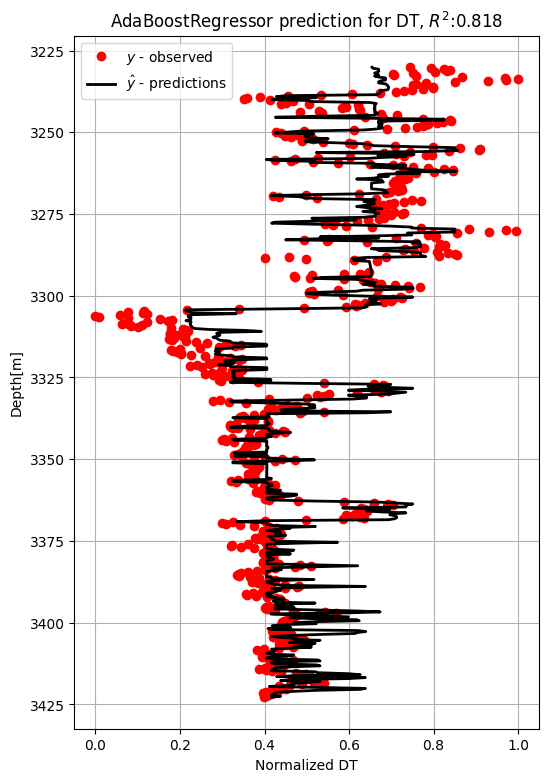

In [241]:
plt.figure(figsize=(6,9))
plt.plot(y_te,test_df['MD'],'ro')
plt.plot(y_hat,test_df['MD'], 'k', lw=2)
plt.gca().invert_yaxis()
plt.title(f'{best_model} prediction for {output[0]}, $R^2$:{r2_score(y_te, y_hat):.3f}')
plt.xlabel(f'Normalized {output[0]}')
plt.ylabel('Depth[m]')
plt.legend(['$y$ - observed','$\hat{y}$ - predictions'])
plt.grid()


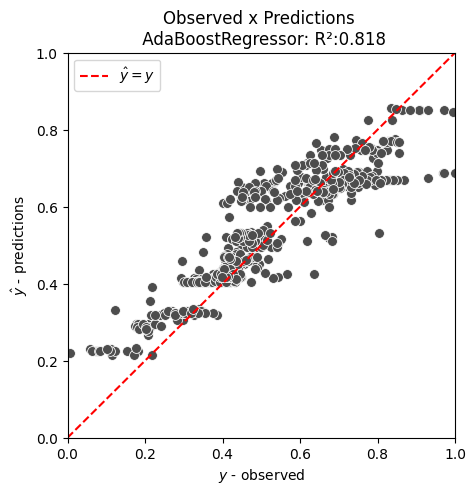

In [243]:
fig = plt.figure(figsize=(5,5))
# fig = plt.figure(figsize=(12,12))
lim =(0,1)

sns.scatterplot(x=y_te.ravel(), y=y_hat.ravel(), s=50, color='.3')
# sns.kdeplot(x=y_te.ravel(), y=y_hat.ravel(), levels=10, linewidths=1, thresh=0.01, color='grey')

plt.plot(lim, lim, 'r--', label='$\hat{y}=y$')
plt.xlim(lim)
plt.ylim(lim)

plt.xlabel('$y$ - observed')
plt.ylabel('$\hat{y}$ - predictions')

plt.legend(loc='upper left')

plt.title(f"Observed x Predictions \n {df_results.loc[0,'MODEL']}: R²:{df_results.loc[0,'R2_TE']:.3f}")

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '7_crossplot_y_yhat.eps')
# fig.savefig(p, format='eps')
pass;

In [248]:
prefix = 'REG_DT_FILT'
binary = os.path.join(os.getcwd(), 'Outputs', f'{prefix}.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump(df_results, bin_file)


c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\Mestrado\SYSID_well_logs\Outputs\REG_DT_FILT.pkl


#### Estudos dos parametros e tempos de treinamento e param

In [291]:
for i,m in enumerate(df_results['MODEL_OBJ']):
    dfp = m.best_estimator_.get_params()
    print (m.best_estimator_.__class__.__name__, dfp)

AdaBoostRegressor {'estimator': None, 'learning_rate': 0.207482446656461, 'loss': 'exponential', 'n_estimators': 85, 'random_state': 48}
XGBRegressor {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.13149387720039063, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 40, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_me

In [300]:
for i,m in enumerate(df_results['MODEL_OBJ']):
    estim_cvr = m.cv_results_
    print (f"{m.best_estimator_.__class__.__name__}:", f"{np.mean(estim_cvr['mean_fit_time'])*1000:.0f} ms")

# for i,m in enumerate(df_rank['MODEL_OBJ']):
# if m.estimator.cv == 'prefit': #stack
#     print (m.estimator.final_estimator_.best_estimator_)
# else: #no stack
#     print (m.estimator.best_estimator_)

AdaBoostRegressor: 226 ms
XGBRegressor: 589 ms
SVR: 21 ms
LGBMRegressor: 1533 ms
LinearRegression: 1 ms
DecisionTreeRegressor: 4 ms
RandomForestRegressor: 180 ms
ExtraTreesRegressor: 238 ms
BaggingRegressor: 250 ms
Pipeline: 2 ms
GradientBoostingRegressor: 375 ms
KNeighborsRegressor: 1 ms
MLPRegressor: 1277 ms
